# Exercise 5

O churn é uma métrica que indica a taxa de clientes que é perdida por uma empresa. Esta métrica pode ser muito importante, dado que se mobilizar para manter seus clientes pode ser muito menos custoso do que obter novos clientes. Neste exercício estudaremos o churn em um banco. Para tal, usaremos os dados disponíveis em aqui. As unidades amostrais são clientes e ex-clientes do banco.

[Churn dataset](https://github.com/rbstern/causality_book/blob/master/code/dados/churn.csv).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from data import make_confounded_data

df_rnd, df_obs, df_cf = make_confounded_data(50_000)
df_obs.head(3)

,sex,age,severity,medication,recovery
0,0,16.354103,0.047350,0.0,14
1,1,24.182983,0.099184,0.0,27
2,1,25.483159,0.349073,1.0,14


In [2]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork()
model.add_nodes_from(list(df_obs.columns))
model.add_edges_from(
    [
        ("age", "severity"),
        ("sex", "medication"),
        ("age", "medication"),
        ("age", "recovery"),
        ("sex", "recovery"),
        ("severity", "recovery"),
        ("medication", "recovery"),
    ]
)

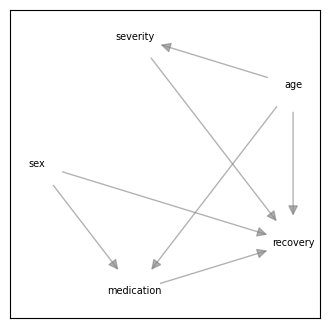

In [3]:
import networkx as nx
# import pylab as plt

plt.figure(figsize=(4, 4))

nx_graph = nx.DiGraph(model.edges())
position_dicts = nx.shell_layout(nx_graph)

nx.draw_networkx_edges(
    nx_graph,
    position_dicts,
    edge_color="gray",
    node_size=1500,
    alpha=0.6,
    arrowstyle="-|>",
    arrowsize=15,
)
nx.draw_networkx_labels(nx_graph, position_dicts, font_size=7, font_color="black")
plt.show()

In [4]:
from pgmpy.inference import CausalInference

inference = CausalInference(model=model)

proposed_backdoor_set = ["sex", "age", "severity"]

assert inference.is_valid_backdoor_adjustment_set(
    "medication", "recovery", proposed_backdoor_set
)

In [5]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split

def return_XZ_y(df, backdoor_set_list):
    return df.filter(backdoor_set_list), np.array(df.recovery)

In [6]:
df_train, df_test = train_test_split(
    df_obs.assign(recovery_cf=df_cf.recovery),
    test_size=0.2,
    random_state=42,
)

XZ_train_med0, y_train_med0 = return_XZ_y(df_train.query("medication == 0"), proposed_backdoor_set)
XZ_train_med1, y_train_med1 = return_XZ_y(df_train.query("medication == 1"), proposed_backdoor_set)

XZ_test, y_test = return_XZ_y(df_test, proposed_backdoor_set)

In [7]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import HistGradientBoostingRegressor

class ConformalizedQuantileRegression(BaseEstimator):
    def __init__(self, alpha=0.1, calibration_size=0.3, random_state=42):
        self.alpha = alpha
        self.calibration_size = calibration_size
        self.random_state = random_state
    
    def _return_quantile_model(self, quantile):
        return GridSearchCV(
                estimator=HistGradientBoostingRegressor(random_state=self.random_state, loss='quantile', quantile=quantile),
                cv=KFold(shuffle=True, random_state=self.random_state),
                param_grid={"max_depth": [2, 5, 10, None]},
                scoring="neg_mean_squared_error",
                n_jobs=-1
        )
    
    def fit(self, X, y):
        X_train, X_cal, y_train, y_cal = train_test_split(
            X, y, test_size=self.calibration_size, random_state=self.random_state)

        self.model_lower_ = self._return_quantile_model(quantile=self.alpha/2).fit(X, y)
        self.model_upper_ = self._return_quantile_model(quantile=1 - self.alpha/2).fit(X, y)
        
        self.y_cal_conformity_scores_ = np.maximum(
            self.model_lower_.predict(X_cal) - y_cal, 
            y_cal - self.model_upper_.predict(X_cal))
        self.quantile_conformity_scores_ = np.quantile(self.y_cal_conformity_scores_, 1-self.alpha)
        
        return self

    def predict(self, X):
        y_test_interval_pred_cqr = np.column_stack(
            [self.model_lower_.predict(X) - self.quantile_conformity_scores_,
             self.model_upper_.predict(X) + self.quantile_conformity_scores_])
        return y_test_interval_pred_cqr

In [8]:
model_med0 = ConformalizedQuantileRegression().fit(XZ_train_med0, y_train_med0)
y_test_interval_pred_cqr_med0 = model_med0.predict(XZ_test)

model_med1 = ConformalizedQuantileRegression().fit(XZ_train_med1, y_train_med1)
y_test_interval_pred_cqr_med1 = model_med1.predict(XZ_test)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

ps =  LogisticRegression(
    random_state=42,
).fit(df_train.drop(columns=["medication", "recovery", "recovery_cf"]), df_train.medication)

roc_auc_score(df_test.medication, ps.predict_proba(XZ_test)[:, 1])

0.9806383470037248

In [10]:
df_val = (
    df_test
    .assign(pred_lower_med_0=y_test_interval_pred_cqr_med0[:, 0])
    .assign(pred_upper_med_0=y_test_interval_pred_cqr_med0[:, 1])
    .assign(ic_size_med_0=lambda df_: df_.pred_upper_med_0 - df_.pred_lower_med_0)
    .assign(pred_lower_med_1=y_test_interval_pred_cqr_med1[:, 0])
    .assign(pred_upper_med_1=y_test_interval_pred_cqr_med1[:, 1])
    .assign(ic_size_med_1=lambda df_: df_.pred_upper_med_1 - df_.pred_lower_med_1)
    .assign(prob=ps.predict_proba(XZ_test)[:, 1])
    .assign(cut=lambda df_: pd.qcut(df_.prob, q=5, labels=False))
    .assign(match=lambda df_:
            np.select(condlist=[df_.medication == 0],
                      choicelist=[(df_.recovery > df_.pred_lower_med_0) & (df_.recovery < df_.pred_upper_med_0)],
                      default=(df_.recovery > df_.pred_lower_med_1) & (df_.recovery < df_.pred_upper_med_1)))
    .assign(match_cf=lambda df_:
            np.select(condlist=[df_.medication != 0],
                      choicelist=[(df_.recovery_cf > df_.pred_lower_med_0) & (df_.recovery_cf < df_.pred_upper_med_0)],
                      default=(df_.recovery_cf > df_.pred_lower_med_1) & (df_.recovery_cf < df_.pred_upper_med_1)))
)

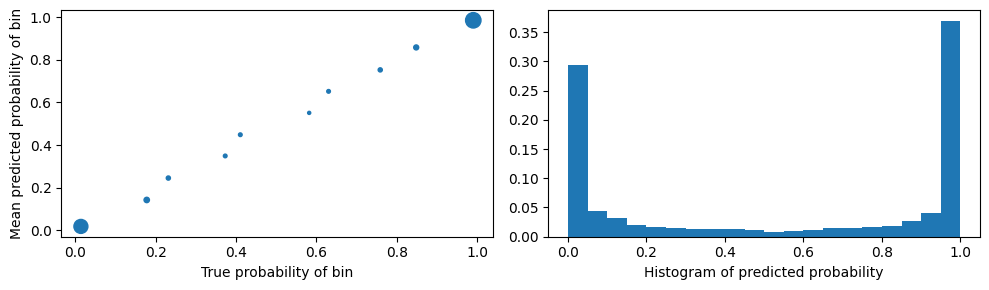

In [11]:
from cal3 import calibration_curve

prob_true, prob_pred, size_bin = calibration_curve(df_val.medication, df_val.prob, n_bins=10)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].scatter(prob_true, prob_pred, s=(0.03*size_bin).astype(int))
ax[0].set_xlabel("True probability of bin")
ax[0].set_ylabel("Mean predicted probability of bin")
ax[1].hist(df_val.prob, bins=np.linspace(0, 1, 21), weights=np.ones_like(df_val.prob)/df_val.shape[0])
ax[1].set_xlabel("Histogram of predicted probability")
plt.tight_layout()

In [12]:
from scipy.stats import bootstrap
def bootstrap_ci(x, ci=0.95):
    boot = bootstrap((x,), np.mean, confidence_level=ci)
    return np.round(boot.confidence_interval, 5)

In [13]:
aux1 = (
    df_val
    .groupby("cut")
    .match
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match": "match_confidence_interval"})
)

aux2 = (
    df_val
    .groupby("cut")
    .match_cf
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match_cf": "match_cf_confidence_interval"})
)

aux3 = (
    df_val
    .groupby("cut")
    .agg({"match": np.mean, "match_cf": np.mean, "ic_size_med_0": np.mean, "ic_size_med_1": np.mean})
    .rename(columns=lambda col: col + "_mean")
)

pd.concat([aux1, aux2, aux3], axis=1).reset_index()

,cut,match_confidence_interval,match_cf_confidence_interval,match_mean,match_cf_mean,ic_size_med_0_mean,ic_size_med_1_mean
0,0,"[0.8715, 0.899]","[0.8595, 0.889]",0.8860,0.8750,14.168622,10.393199
1,1,"[0.8675, 0.896]","[0.863, 0.8915]",0.8820,0.8780,17.334568,10.412515
2,2,"[0.873, 0.901]","[0.852, 0.882]",0.8875,0.8680,20.504580,12.471160
3,3,"[0.8905, 0.917]","[0.771, 0.8065]",0.9040,0.7890,25.366233,15.197359
4,4,"[0.8775, 0.9045]","[0.228, 0.265]",0.8920,0.2465,27.026146,18.402627


Esperava que o primeiro quantil tivesse um IC size do med1 maior já que teoricamente temos poucos exemplos para essa região. Mas aparentemente, ele tem bastante confiança mesmo nessa região...

In [15]:
aux1 = (
    df_val
    .groupby(["cut", "medication"])
    .match
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match": "match_confidence_interval"})
)

aux2 = (
    df_val
    .groupby(["cut", "medication"])
    .match_cf
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match_cf": "match_cf_confidence_interval"})
)

aux3 = (
    df_val
    .groupby(["cut", "medication"])
    .agg({"match": np.mean, "match_cf": np.mean, "ic_size_med_0": np.mean, "ic_size_med_1": np.mean}) # 
    .rename(columns=lambda col: col + "_mean")
)

pd.concat([aux1, aux2, aux3], axis=1).reset_index().sort_values(by=["medication", "cut"])

C:\Users\carlo\AppData\Local\pypoetry\Cache\virtualenvs\causal-inference-9VSbwcsw-py3.10\lib\site-packages\scipy\stats\_resampling.py:144: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
C:\Users\carlo\AppData\Local\pypoetry\Cache\virtualenvs\causal-inference-9VSbwcsw-py3.10\lib\site-packages\scipy\stats\_resampling.py:97: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


,cut,medication,match_confidence_interval,match_cf_confidence_interval,match_mean,match_cf_mean,ic_size_med_0_mean,ic_size_med_1_mean
0,0,0.0,"[0.87174, 0.8998]","[0.85972, 0.88928]",0.886273,0.874749,14.166383,10.392999
2,1,0.0,"[0.86801, 0.89734]","[0.85932, 0.88973]",0.883216,0.875068,17.278133,10.396031
4,2,0.0,"[0.85548, 0.90194]","[0.86452, 0.90968]",0.880000,0.889032,19.503400,11.924443
6,3,0.0,"[0.73529, 0.97059]","[0.70588, 0.94118]",0.882353,0.852941,26.329864,14.692039
1,0,1.0,"[0.25, 1.0]","[nan, nan]",0.750000,1.000000,15.285502,10.493189
3,1,1.0,"[0.80503, 0.91195]","[0.86164, 0.94969]",0.867925,0.911950,17.988006,10.603375
5,2,1.0,"[0.87347, 0.90857]","[0.83429, 0.87429]",0.892245,0.854694,21.137980,12.817042
7,3,1.0,"[0.89064, 0.91658]","[0.76907, 0.80519]",0.904374,0.787894,25.349568,15.206098
8,4,1.0,"[0.878, 0.905]","[0.2285, 0.266]",0.892000,0.246500,27.026146,18.402627


Tem regiões que não tem ninguém do outro tratamento kkkk ._.

___